<a href="https://colab.research.google.com/github/jzj5528/DS340W/blob/main/beat_the_bookmakers_with_machine_learning_tennis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this Kernel we'll beat the bookmakers by betting on some well-chosen tennis matches !  

All the data is taken from http://tennis-data.co.uk/data.php.  
We have all the tennis matches played in the ATP World Tour (Grand Slams, Masers, Master 1000 & ATP500) since January 2000, and until March 2018. 

There is much information in this dataset. This notebook will focus only on a quick analysis of the betting market, and propose a betting strategy that generates a non negligible return on investment. 

**OBJECTIVE : get a good return of investment, and be able to guarantee it after a reasonable number of matches. **

The full code is available on github : https://github.com/edouardthom/ATPBetting.git.

# Table of Contents
1. [Introduction : the data and some definitions](#introduction)
2. [Assessment of some basic strategies ](#basic)
    1. [Betting on all matches](#all_matches)
    2. [Betting on a selection of matches](#selection_matches)
3. [The proposed strategy](#proposed_strategy)
    1. [Confidence computation](#confidence)
    2. [Performance of the prediction](#performance)
    3. [Final ROI](#final_roi)
    4. [Roi variability study](#variability) 
4. [Conclusion](#conclusion)

# Introduction : the data and some definitions <a name="introduction"></a>

### Some important definitions : odds and ROI

Let's say you bet 10€ on Djokovic with an odd of 1.3

* If he wins, you go back home with your 10€, plus 3€ of benefits
* If he loses you go back home with 0€  
   
   
* If he wins, as you bet 10€ and won 13€, we say that your ROI (return on investment) is 30%
* If he looses, your ROI in -100%

### The tennis matches data 

In [1]:
from google.colab import drive
from google.colab import files

In [2]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [20]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

data=pd.read_csv('/content/gdrive/My Drive/DS340W/atp_data.csv.zip',low_memory=False)
data.Date = data.Date.apply(lambda x:datetime.strptime(x, '%Y-%m-%d'))

The dataset "atp_data.csv" is directly built from the data you can find on http://tennis-data.co.uk/data.php. I selected the columns that will be useful for the betting model, and added the elo rankings of the players at the beginning of each match.

We have all the matches played on the ATP World Tour from January 2000 to March 2018.

One row per match. And we have some information about each match :

In [21]:
print("Total number of matches : "+str(len(data)))

Total number of matches : 44708


In [22]:
print(list(data.columns))

['ATP', 'Location', 'Tournament', 'Date', 'Series', 'Court', 'Surface', 'Round', 'Best of', 'Winner', 'Loser', 'WRank', 'LRank', 'Wsets', 'Lsets', 'Comment', 'PSW', 'PSL', 'B365W', 'B365L', 'elo_winner', 'elo_loser', 'proba_elo']


For each of the matches, you have the Tournament, Date, match winner, match loser,  surface, tournament round, the ATP rankings of the winner and the loser... These informations will be useful to build features for the model.

**And very important :** the odds of 2 bookmakers, Pinnacle and Bet365 (odds at the beginning of the match)

With this information we can estimate the ROI of any betting strategy.

Now let's begin by assessing the ROI of simple strategies...

# Assessment of some basic strategies <a name="basic"></a>

In [23]:
def basic_horizontal_barplot(values,labels,xaxis_label,title,xlim=None,figsize=None):
    """
    Please provide the labels corresponding to the values, the plot title, and the xaxis label.
    """
    # Possible colors to use - if not enough, colors are reused
    cs=["coral","tomato","peachpuff","orange","gold","firebrick","peru","khaki","chocolate"]
    cs=cs*(len(values)//len(cs)+1)
    # The figure
    if figsize==None:
        fig=plt.figure(figsize=(4,3))
    else:
        fig=plt.figure(figsize=figsize,dpi=100)
    ax = fig.add_axes([0,0,1,0.9])
    color=cs[:len(values)]
    ax.barh(range(len(values)),values,color=color)
    ax.set_yticks(range(len(values)))
    ax.set_yticklabels(labels)
    if xlim!=None:
        ax.set_xlim(xlim)
    plt.suptitle(title)
    ax.set_xlabel(xaxis_label)
    plt.show()

## Betting on all matches <a name="all_matches"></a>

Let's say we decide to bet on all matches between January 2011 and march 2018.

In [24]:
beg=datetime(2011,1,1) 
end=data.Date.iloc[-1]
indices=data[(data.Date>beg)&(data.Date<=end)].index
data_sel=data[["B365W","B365L","PSW","PSL","WRank","LRank"]]
data_sel=data.iloc[indices,:]
print("Number of matches during this period : "+str(len(data_sel)))

Number of matches during this period : 16412


*(with such a number of matches the confidence intervals will be very small)*

3 possible strategies are :
* always betting on the player with the smallest odd
* always betting on the player with the best ATP ranking
* betting completely at random for each match : "head or tail betting"

In the following graph we compare these 3 strategies for the 2 bookmakers.

**Precision :** we bet the same amount of money on each match.

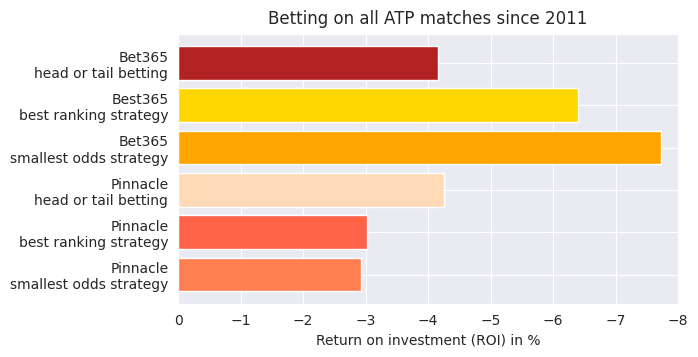

In [25]:
## Comparison of some basic strategies
roi_smallest_odd_ps=100*(data_sel.PSW[data_sel.PSW<data_sel.PSL].sum()-len(data_sel))/len(data_sel)
roi_best_ranking_ps=100*(data_sel.PSW[data_sel.WRank<data_sel.LRank].sum()-len(data_sel))/len(data_sel)
roi_random_ps=100*(data_sel.sample(int(len(data_sel)/2)).PSW.sum()-len(data_sel))/len(data_sel)
roi_smallest_odd_365=100*(data_sel.B365W[data_sel.B365W<data_sel.B365L].sum()-len(data_sel))/len(data_sel)
roi_best_ranking_365=100*(data_sel.B365W[data_sel.WRank<data_sel.LRank].sum()-len(data_sel))/len(data_sel)
roi_random_365=100*(data_sel.sample(int(len(data_sel)/2)).PSW.sum()-len(data_sel))/len(data_sel)
values=[roi_smallest_odd_ps,roi_best_ranking_ps,roi_random_ps,
        roi_smallest_odd_365,roi_best_ranking_365,roi_random_365]
labels=["Pinnacle\nsmallest odds strategy","Pinnacle\nbest ranking strategy","Pinnacle\nhead or tail betting",
       "Bet365\nsmallest odds strategy","Best365\nbest ranking strategy","Bet365\nhead or tail betting"]
xaxis_label="Return on investment (ROI) in %"
title="Betting on all ATP matches since 2011"
basic_horizontal_barplot(values,labels,xaxis_label,title,[0,-8],(5,3))

*(it means for example that if during 1000 matches we bet 1€ on the best ranked player on Pinnacle, we can expect to loose approximately 26€ in the end)*

Pinnacle has a reputation of having the best odds. It seems to deserve well its reputation. A global loss of ~2% is very low. On the contrary Bet365 seems to take a much higher commission than Pinnacle.


Considering the ROI of the random strategy, it is the best strategy on Bet365 and the worse on Pinnacle. One possible explanantion is that Bet365 is intended to more unexperienced gamblers. They might have noticed that their gamblers tend to overbet on the best ranked player, so to mitigate the risk they decrease the odds of the best ranked players. But we'll go back to these bookmakers techniques later...
  
  
**Now let's imagine we know in advance the result of each match. So we always bet on the winner of the match.**

What is the ROI we can expect ?

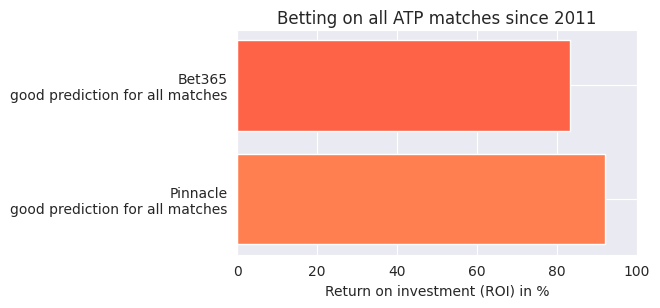

In [26]:
## Maximum possible ROI
max_roi_ps=100*(data_sel.PSW.sum()-len(data_sel))/len(data_sel)
max_roi_365=100*(data_sel.B365W.sum()-len(data_sel))/len(data_sel)
values=[max_roi_ps,max_roi_365]
labels=["Pinnacle\ngood prediction for all matches","Bet365\ngood prediction for all matches"]
xaxis_label="Return on investment (ROI) in %"
title="Betting on all ATP matches since 2011"
basic_horizontal_barplot(values,labels,xaxis_label,title,[0,100],(4,2.5))

Therefore if we bet on all matches we can't expect a ROI above 92%.

Once again it appears that Pinnacle is much more friendly than Bet365.

In the following we'll focus on Pinnacle only.

## Betting on a selection of matches <a name="selection_matches"></a>

**Idea :** instead of betting on all matches, we could focus on some matches where we are especially confident. 

In the following, every betting strategy will output a "confidence dataset". For each match it will contain the confidence in each player. From this dataset, we can set a threshold and bet only on the matches where our confidence is beyond a certain threshold.

As an example, we begin with a simple hypothetical strategy. We can say that our confidence is the odd itself. Therefore the greater the odd of a player the greater our will to bet on him. Let's imagine we know the winner of each match in advance and we bet only on the X% of players with the highest odds. This would be the perfect strategy in a world where we are omniscient.

What would be our ROI ?

In [27]:
def profitComputation(percentage_matchs,conf,model_name="0"):
    """
    Given a confidence dataset and a percentage of matches, computes the ROI 
    if we bet only on the percentage of matches we have the most confidence in
    (same amount for each match).
    """
    coeff=percentage_matchs/100
    lim=int(coeff*len(conf))
    conf=conf.sort_values("confidence"+model_name,ascending=False)
    conf=conf.iloc[:lim,:]
    profit=100*(conf.PSW[conf["win"+model_name]==1].sum()-len(conf))/len(conf)
    return profit

def plotProfits(conf,title=""):
    """
    Given a confidence dataset, plots the ROI according to the percentage of matches
    we bet on. 
    """
    profits=[]
    ticks=range(5,101)
    for i in ticks:
        p=profitComputation(i,conf)
        profits.append(p)
    fig=plt.figure(figsize=(7,4),dpi=100)
    plt.plot(ticks,profits)
    plt.xticks(range(0,101,5))
    plt.xlabel("% of matches we bet on")
    plt.ylabel("Return on investment (%)")
    plt.suptitle(title)
    plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  """Entry point for launching an IPython kernel.


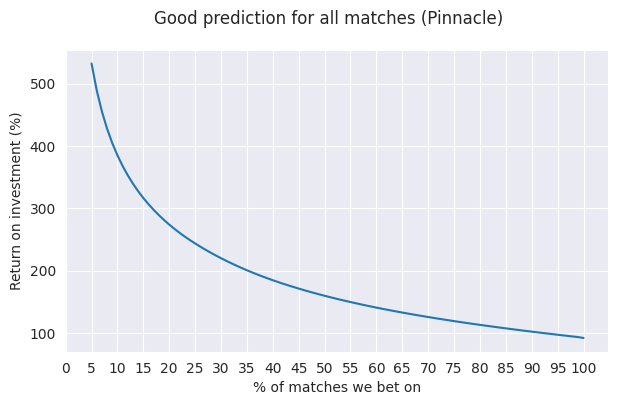

In [28]:
perfect_conf=pd.concat([data_sel[["Date","PSW","PSL"]]],1)
perfect_conf["win0"]=[1]*len(perfect_conf)
perfect_conf["confidence0"]=perfect_conf.PSW
perfect_conf=perfect_conf.rename(columns={"Date":"date"})
plotProfits(perfect_conf,"Good prediction for all matches (Pinnacle)")

As we can see if we bet on 100% of the matches, and we are right each time, we find again the ROI we found above (92%).

But if we bet only on the matches we are the most confident in (in our ideal case the match with the highest odds) our ROI is much higher.


**Betting on a subset of matches is in general a good strategy.** It is hard to get a good ROI by betting on ALL matches, but it is feasible with a subset. The only limit being the percentage of matches we bet on. If it is too small, the number of matches we bet on is low and the ROI has a high variability.

# The proposed strategy <a name="proposed_strategy"></a>

XGBoost will predict a probability for the 2 possible outcomes of each match (player A wins / player B wins).

Our confidence in an outcome will be : the predicted probability divided by the probability implied by the bookmaker.

*(The probability implied by the bookmaker is the inverse of the odd.)*

Then we bet only on the outcomes with the highest confidence.     *(what threshold for the confidence ? we'll see it later...)*

**Example :** 

* There is an odd of 2.5 on the victory of Zverev against Nadal
* This odd tells us it is unlikely to happen
* More precisely the probability implied by the bookmaker is 1/2.5 = 0.4
* But our model tells us the real probability is 0.8, so Zverev is the favourite
* It might be because Nadal is overpriced (because he is Nadal)
* But we won't be fooled 
* Our confidence is here 0.8/0.4 = 2
* It's a high confidence, we can bet on this match !

## Confidence computation <a name="confidence"></a>

To test this whole betting strategy, we'll take time into account. 

We train a model to predict the outcome of each match given the last 10700. Out of the 10700, 300 are devoted to validation - the 300 consecutive matches right before the match we want to predict.

To make the process quicker, and as it doesn't harm the ROI, instead of training a new model to predict each match, we make the same model predict 2000 matches at a time.

The features used are various. we can cite :
* The Pinnacle odds
* For each player the percentage of matches won during the last X days
* For each player the number of matches played during the last X days
* For each player the number of recent wounds
* The Elo rankings of the players
* ...
I also directly one-hot encoded the players with the most matches.

As the code to build the training set is a little bit too long for this kernel, you can find it in this github repo :
https://github.com/edouardthom/ATPBetting.git. The result of some computation is in the github in the folder "Generated Data". This is where you can find the dataframe used in the 2nd part.

We'll import the dataset with the prediction (and the confidence level) for each match, and study it.

In [31]:
# Our predictions + confidence level + if we were right or not
conf=pd.read_csv('/content/gdrive/My Drive/DS340W/confidence_data.csv')
print("Total number of matches predicted : "+str(len(conf)))

Total number of matches predicted : 11054


In [32]:
conf.iloc[:6,:]

,match,PSW,win0,confidence0,date
0,20445,2.85,1,2.037852,2016-07-22
1,19518,1.41,0,1.973181,2016-04-16
2,15396,3.15,1,1.950877,2013-08-13
3,18868,1.55,0,1.914305,2016-01-25
4,22118,2.70,1,1.888781,2017-04-18
5,20581,2.86,1,1.866368,2016-08-15


You can see that for each of the matches we have :
* its date
* our confidence in the outcome we chose
* if the outcome we chose is the right one (ie. if we bet on the winner of the match)
* the odds corresponding to the outcome we chose

## Performance of the prediction <a name="performance"></a>

What is the percentage of matches we predicted right ?

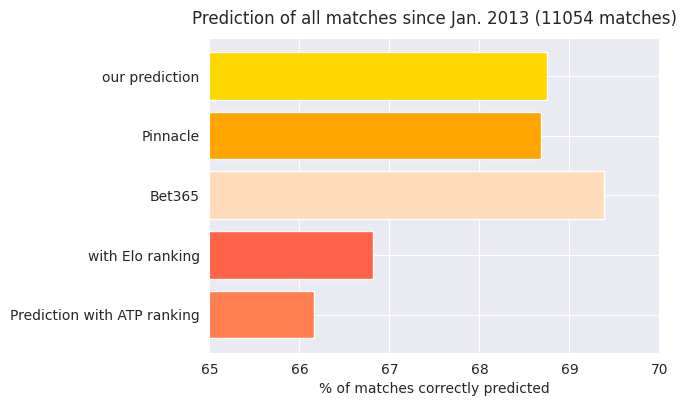

In [33]:
# Comparison of different techniques for the winner prediction
# Interval for the comparison : [beg,end]
beg=datetime(2013,1,1)
end=data.Date.iloc[-1]
indices=data[(data.Date>=beg)&(data.Date<=end)].index
# classical ATP ranking
test=data[["WRank","LRank"]].iloc[indices,:]
atp=100*(test.LRank>test.WRank).sum()/len(indices)
# Elo ranking
test=data.iloc[indices,:]
elo=100*(test.elo_winner>test.elo_loser).sum()/len(indices)
# Bookmakers
test=data.iloc[indices,:]
book_pi=100*(test.PSW<test.PSL).sum()/len(indices)
book_365=100*(test.B365W<test.B365L).sum()/len(indices)
# Our prediction
our=100*conf.win0.sum()/len(conf)
# Plot
labels=["Prediction with ATP ranking","with Elo ranking",
        "Bet365","Pinnacle",
        "our prediction"]
values=[atp,elo,book_pi,book_365,our]
xaxis_label="% of matches correctly predicted"
title="Prediction of all matches since Jan. 2013 ("+str(len(indices))+" matches)"
xlim=[65,70]
basic_horizontal_barplot(values,labels,xaxis_label,title,xlim,figsize=(4.5,3.5))

We can remark that our prediction is not especially incredible. 

We predicted 68.7% of matches right.

**But this is not the final objective, we want the best ROI.** 

If we are often wrong but right only on the matches with high odds, it's ok !

In fact all the hyperparameters of the models were chosen to maximize the ROI, and not the prediction accuracy.

## Final ROI <a name="final_roi"></a>

With our predictions and their associated confidence levels, we can now see what would have happened if we had bet only on the X% matches we are the most confident in the outcome.

*Reminder : we bet the same amount of money per match*

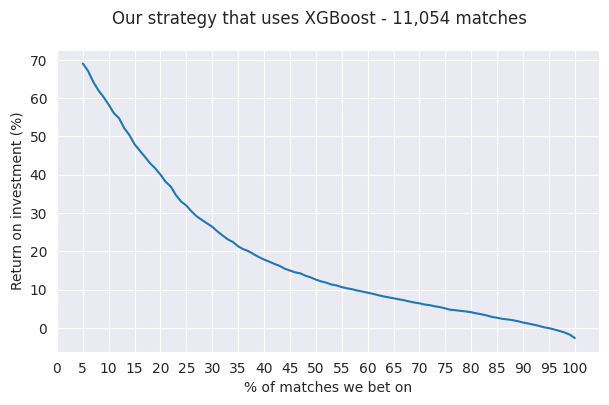

In [34]:
plotProfits(conf,title="Our strategy that uses XGBoost - 11,054 matches")

If we bet on ALL the matches, we loose money :(

**But if we bet on 5% of the matches, we get a ROI of 70% !**

Now this study would be incomplete if we didn't study the variance and stationarity of the ROI.

## ROI variability study <a name="variability"></a>

Compared to other sports, the number of matches in tennis is rather low (~2200/year).

If we choose to bet only on 1% of matches, you see the problem...

We don't want to wait too long to guarantee our ROI. 

**Let's say in general we are willing to wait 117 consecutive matches. And we'll bet on a part of these 117 matches.**

(in a grand slam there are 117 matches, occurring in 2 weeks)

In [35]:
def profitsAlongTime(conf,matches_delta):
    span_matches=span_matches=conf.match.max()-conf.match.min()-1
    N=int(span_matches/matches_delta)+1
    milestones=np.array([conf.match.min()+matches_delta*i for i in range(N)])
    profits=[]
    lens=[]
    for i in range(N-1):
        beg=milestones[i]
        end=milestones[i+1]-1
        conf_sel=confconf[(conf.match>=beg)&(conf.match<=end)]
        l=len(conf_sel)
        lens.append(l)
        if l==0:
            profits.append(0)
        else:    
            p=profitComputation(100,conf_sel)
            profits.append(p)
    profits=np.array(profits)
    return profits,lens

According to the curve above, betting on 10% of the matches leads to an average ROI of 58%.

We decide to bet on **10%** of the matches : the 10% with the highest confidence between 2013 and 2018 (~1100 matches).

We have to check first that these matches are well spread between 2013 and 2018.

In the graph below, each point corresponds to a section of 117 consecutive matches. As we applied the model on 11,000 matches, there are approximately 100 points. The ideal case would be a value of 10% * 117 ~ 11 on the y-axis for all points, which means the model tells us to bet on 11 or 12 matches in every 117 consecutive matches.

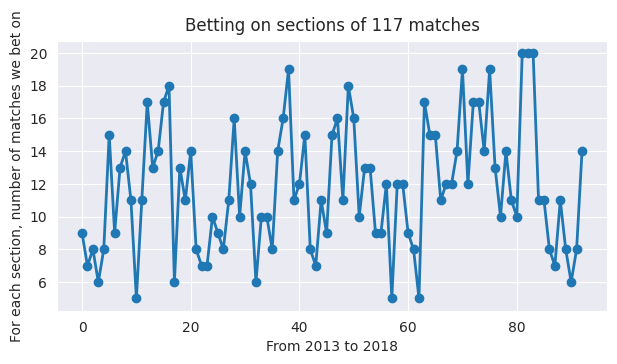

In [36]:
confconf=conf.iloc[:int(0.1*len(conf)),:]
profits,lens=profitsAlongTime(confconf,117)
fig=plt.figure(figsize=(5.5,3),dpi=100)
ax = fig.add_axes([0,0,1,0.9])  
ax.plot(lens,linewidth=2,marker="o")
plt.suptitle("Betting on sections of 117 matches")
ax.set_xlabel("From 2013 to 2018")
ax.set_ylabel("For each section, number of matches we bet on")
plt.show()

The matches we are the most confident in are well spread accross the study period.

That indicates a certain stability in the betting market.

Now let's see our ROI for the consecutive sections of 117 matches between 2013 and 2018.

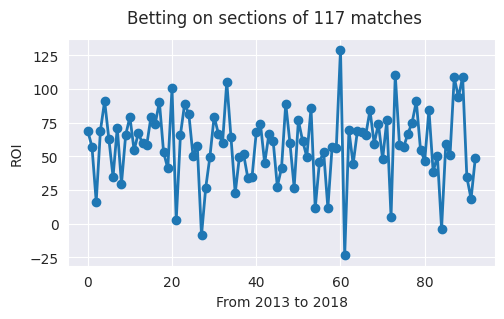

In [37]:
conf10=conf.iloc[:int(0.1*len(conf)),:]
profits,lens=profitsAlongTime(conf10,117)
fig=plt.figure(figsize=(5.5,3),dpi=100)
plt.plot(profits,linewidth=2,marker="o")
plt.suptitle("Betting on sections of 117 matches")
plt.xlabel("From 2013 to 2018")
plt.ylabel("ROI")
plt.show()

There is a great variability but the process seems quite stationary. 

To sum up, a strategy that gives a good ROI in 2013 still gives a good ROI in 2018, which is quite reassuring.

But such a variability would force us to wait much more that 117 matches to guarantee the 58% ROI...

**Now let's bet on 35% of the matches (~3850 matches). In this case the average ROI over our study period in 20%.**

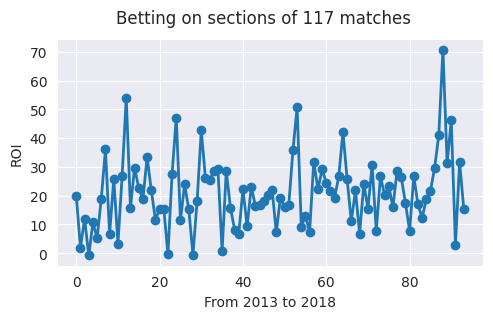

In [38]:
confconf=conf.iloc[:int(0.35*len(conf)),:]
profits,lens=profitsAlongTime(confconf,117)
fig=plt.figure(figsize=(5.5,3),dpi=100)
plt.plot(profits,linewidth=2,marker="o")
plt.suptitle("Betting on sections of 117 matches")
plt.xlabel("From 2013 to 2018")
plt.ylabel("ROI")
plt.show()

In [39]:
print("Standard deviation : "+str(round(profits.std(),1)))

Standard deviation : 12.5


**By betting on 35% of the matches, by sections of 117 consecutive matches, we almost never loose money !**

# Conclusion <a name="conclusion"></a>

A comfortable observation is that the betting market seems quite stationary, which is a condition for powerful and secure betting strategies.

It also appears that making steady money with tennis betting is possible. 
The technique above gives a **ROI of 20% by betting on 35% of the matches** (on Pinnacle).
And there seems to be a lot of techniques and improvements to explore to make it bigger.

Don't hesitate to tell me if you see any mistake, especially any leak.

I hope you liked this kernel ! :)